---
# **Ecuación del diodo de Shockley usando un ESP32 controlado por LabView**
---
Andrés Felipe Riaño Quintanilla     1083928808

Santiago Julio Dávila               1000413445

---
Laboratorio Avanzado I, Instituto de Física, Universidad de Antioquia

## **Introducción**


Considérese un diodo con juntura p-n. Un diodo de este tipo en polarización directa presenta una corriente que aumenta con el voltaje de acuerdo a la ecuación

$$i(v)=I_S\left[\mathrm{exp}\left(\dfrac{v}{\eta V_T}\right)-1\right]$$

Donde $I_S$ es la corriente de saturación inversa, $v$ es el voltaje aplicado, $V_T=T/11.586$ es el voltaje equivalente a la temperatura y $\eta$ es el coeficiente de emisión, definido como 2 para dispisitivos de silicio y 1 para dispositivos de germanio. Esta ecuación es fácil de verificar con un montaje experimental sencillo que incluye un diodo, una resistencia y una fuente de voltaje, que en este caso, será provista por un Arduino ESP32. Esta ecuación se puede aproximar considerando que la corriente de saturación inversa es típicamente muy pequeña, de modo que el segundo término de la ecuación puede despreciarse, de modo que la ecuación queda:

$$i(v)\approx I_S\mathrm{exp}\left(\dfrac{v}{\eta V_T}\right)$$

Es esta aproximación la que se usará para ajustar los datos.

## **Desarrollo Experimental**

Para el montaje experimental se requirieron los siguientes implementos:

* Diodo
* Resistencia de $1~\text{k}\Omega$
* Espduino-32 HW-707

Se montó el circuito de acuerdo al esquema presentado en la figura 1: se conecta la resistencia a la fuente de voltaje, en este caso el pin de 5 V del ESP32. A la resistencia se conecta el diodo en polarización directa.

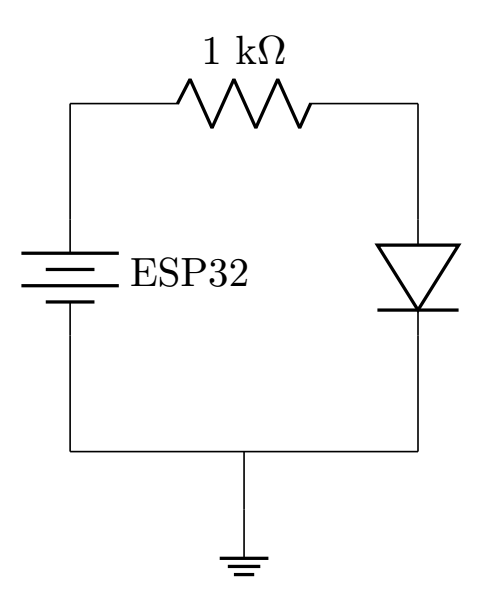

Fig. 1: esquema del circuito.

La adquisición de los datos se hizo con el software LabView que controla el ESP32 desde el computador. El diagrama de bloques se muestra en la figura 2, y se explicará a continuación.

<img src="https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P1/p1-diagrama-1.png" alt="drawing" width="1200"/>

Fig. 2: diagrama de bloques del programa de LabView.

El diagrama consta de una serie de cuadros o _frames_, que corresponden a cada uno de los pasos que el programa ha de ejecutar, y que se explicarán en detalle a continuación:

* **Cuadro 1:** en este cuadro se configura el puerto serial, con la tarjeta que tiene conectada y su respectivo _baud rate_, fijado en 115200 para este caso en particular.
* **Cuadro 2:** este cuadro tiene la función de detener el código si encuentra algún error en su ejecución.
* **Cuadro 3:** este cuadro conecta con la interfaz del usuario, donde hay un botón que da inicio al código al ser activado por el usuario.
* **Cuadro 4:** crea el documento donde se almacenarán los datos y establece el formato en que serán escritos.
* **Cuadro 5:** escribe los valores recolectados por el ESP32 en el archivo creado en el cuadro anterior.
* **Cuadro 6:** programa un delay de 50 milisegundos en la recolección y escritura de los datos.
* **Cuadro 7:** con este cuadro, LabView recolecta los datos de corriente y voltaje obtenidos del ESP32 y los grafica en la interfaz del usuario.
* **Cuadro 8:** guarda el archivo con los datos.

De fondo, LabView se integra con Arduino, que es controlado por la IDE a través del código siguiente:

```
char dato;
int V1, V2;
float Vd, Id;


void setup(){
  Serial.begin(115200);  //Describir la velocidad de comunicación.
  }

void loop (){
  if (Serial.available()>0){  // Si hay bits en el buffer. Revisa si hay datos en el buffer.
    dato = Serial.read();   //Lee el dato que está en el serial
    if (dato == 'a'){
      for(int i = 0; i < 256;i ++){
        dacWrite(25,i);
        delay(30);
        V1 = analogRead(2);
        V2 = analogRead(4);
        Vd = (V1 - V2)*3.3/1023;
        Id = V2*3.3/1023;
        Serial.print(Id);
        Serial.print(";");
        Serial.println(Vd);
        }
      for(int i = 255; i >=0 ;i --){
        dacWrite(25,i);
        delay(30);
        V1 = analogRead(2);
        V2 = analogRead(4);
        Vd = (V1 - V2)*3.3/1023;
        Id = V2*3.3/1023;
        Serial.print(Id);
        Serial.print(";");
        Serial.println(Vd);
        }
      
      }
    
    
    }   
      
    
  }

```

## **Resultados**

Los datos recolectados por el ESP32 se guardaron en un archivo .csv, al cual se le hizo el análisis estadístico y de errores correspondiente utilizando la librería `pandas`.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from scipy.optimize import curve_fit

In [7]:
# Lee el archivo de los datos
df = pd.read_csv('https://raw.githubusercontent.com/SantiagoJulioD/LabAv1/refs/heads/main/LabAv1-P1/datap1.csv')

# Promedios
df['Vd_prom'] = df.apply(lambda x: np.mean([x['Vd_1'],x['Vd_2'],x['Vd_3']]), axis=1)
df['Id_prom'] = df.apply(lambda x: np.mean([x['Id_1']/1000,x['Id_2']/1000,x['Id_3']/1000]), axis=1)

# Error estadístico
df['ErrEst_Vd'] = df.apply(lambda x: np.std([x['Vd_1'],x['Vd_2'],x['Vd_3']]), axis=1)
df['ErrEst_Id'] = df.apply(lambda x: np.std([x['Id_1']/1000,x['Id_2']/1000,x['Id_3']/1000]), axis=1)

# Error experimental
df['ErrExp_Vd'] = np.full(len(df['Vd_1']),3./4095)
df['ErrExp_Id'] = np.full(len(df['Id_1']),3./4095)

# Error dominante
df['ErrDom_Vd'] = df.apply(lambda x: np.max([x['ErrEst_Vd'],x['ErrExp_Vd']]), axis=1)
df['ErrDom_Id'] = df.apply(lambda x: np.max([x['ErrEst_Id'],x['ErrExp_Id']]), axis=1)
df

,Vd_1,Vd_2,Vd_3,Id_1,Id_2,Id_3,Vd_prom,Id_prom,ErrEst_Vd,ErrEst_Id,ErrExp_Vd,ErrExp_Id,ErrDom_Vd,ErrDom_Id
0,0.083516,0.084982,0.085714,109.890110,98.168498,106.227106,0.084737,0.104762,0.000914,0.004896,0.000733,0.000733,0.000914,0.004896
1,0.087179,0.091575,0.088645,87.912088,80.586081,85.714286,0.089133,0.084737,0.001827,0.003070,0.000733,0.000733,0.001827,0.003070
2,0.078388,0.072527,0.071795,97.435897,116.483516,108.424908,0.074237,0.107448,0.002951,0.007807,0.000733,0.000733,0.002951,0.007807
3,0.109890,0.129670,0.112821,59.340659,29.304029,59.340659,0.117460,0.049328,0.008716,0.014159,0.000733,0.000733,0.008716,0.014159
4,0.095238,0.101099,0.087912,81.318681,79.853480,104.029304,0.094750,0.088400,0.005395,0.011067,0.000733,0.000733,0.005395,0.011067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,0.443956,0.460073,0.425641,2556.043956,2547.985348,2583.150183,0.443223,2.562393,0.014066,0.015042,0.000733,0.000733,0.014066,0.015042
252,0.432967,0.433700,0.413919,2567.032967,2574.358974,2627.838828,0.426862,2.589744,0.009157,0.027103,0.000733,0.000733,0.009157,0.027103
253,0.452015,0.449084,0.468864,2547.985348,2580.219780,2490.842491,0.456654,2.539683,0.008716,0.036957,0.000733,0.000733,0.008716,0.036957
254,0.465934,0.504029,0.438095,2534.065934,2512.820513,2616.117216,0.469353,2.554335,0.027026,0.044540,0.000733,0.000733,0.027026,0.044540


Los datos promedio se ajustaron a la forma general de la ecuación del diodo:

$$f(v;a,b)=ae^{bv}$$

In [18]:
# función
def func(x,a,b):
    return a*np.exp(b*x)

# ajuste
params,cov = curve_fit(func,df['Vd_prom'],df['Id_prom'])

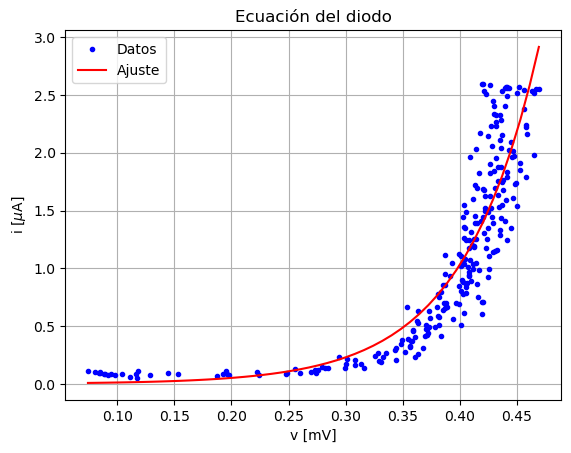

In [17]:
plt.plot(df['Vd_prom'],df['Id_prom'],'b.',label='Datos')
xs = np.linspace(df['Vd_prom'].min(),df['Vd_prom'].max())
plt.plot(xs,func(xs,*params),'r',label='Ajuste')
plt.title('Ecuación del diodo')
plt.xlabel('v [mV]')
plt.ylabel(r'i [$\mu$A]')
plt.legend()
plt.grid()

In [23]:
std = np.diagonal(cov)**0.5
print(f'i=(({params[0]:.4f}±{std[0]:.4f}) μA)exp[(({params[1]:.1f}±{std[1]:.1f}) mV^-1)v]')
print(f'I_S=({params[0]:.4f}±{std[0]:.4f}) μA')
print(f'ηV_T=({(params[1]**-1):.3f}±{(params[1]**-1*std[1]/params[1]):.3f}) mV')

i=((0.0025±0.0008) μA)exp[((15.0±0.7) mV^-1)v]
I_S=(0.0025±0.0008) μA
ηV_T=(0.067±0.003) mV


## **Conclusiones**

* Los datos recolectados de voltaje y corriente en el diodo se ajustan razonablemente bien a una exponencial creciente.
* El ajuste verifica la suposición inicial de que la corriente de saturación es pequeña, siendo esta igual a $(25\pm 8)\times 10^{-4}~\mu\mathrm{A}$.
* Del ajuste se puede obtener el valor de $\eta V_T=(67\pm 3)\times 10^{-3}~\mathrm{mV}$.

## **Referencias**

* Ideal Diode Equation. (2021, Julio 5). https://eng.libretexts.org/@go/page/5924 
* Propagación de errores. (Consultado el 3 de marzo de 2025). https://es.wikipedia.org/wiki/Propagaci%C3%B3n_de_errores